In [1]:
import chess
import chess.svg
from IPython.display import display, SVG
import time

# Tabela wartości figur
piece_values = {
    chess.PAWN: 100,
    chess.KNIGHT: 300,
    chess.BISHOP: 300,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 0
}

# Tabela pozycji figur
# Wartości są przypisane do każdego pola szachownicy dla każdej figury.
# Wartości dodatnie oznaczają korzystną pozycję, a ujemne niekorzystną.
# Pozycje są symetryczne dla białych i czarnych, więc wartości są takie same dla obu kolorów,
# ale z uwzględnieniem, że białe mają swoje wartości na dole
piece_position = {
    chess.PAWN: [
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        10, 10, 20, 30, 30, 20, 10, 10,
        5,  5, 10, 10, 10, 10,  5,  5,
        0,  0,  0, 20, 20,  0,  0,  0,
        5, -5,-10,  0,  0,-10, -5,  5,
        5, 10, 10,-20,-20, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0
    ],

    chess.KNIGHT: [
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20,  0,  0,  0,  0,-20,-40,
        -30,  0, 10, 15, 15, 10,  0,-30,
        -30,  5, 15, 20, 20, 15,  5,-30,
        -30,  0, 15, 20, 20, 15,  0,-30,
        -30,  5, 10, 15, 15, 10,  5,-30,
        -40,-20,  0,  5,  5,  0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50,
    ],

    chess.BISHOP: [
        -20,-10,-10,-10,-10,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5, 10, 10,  5,  0,-10,
        -10,  5,  5, 10, 10,  5,  5,-10,
        -10,  0, 10, 10, 10, 10,  0,-10,
        -10, 10, 10, 10, 10, 10, 10,-10,
        -10,  5,  0,  0,  0,  0,  5,-10,
        -20,-10,-10,-10,-10,-10,-10,-20,
    ],

    chess.ROOK: [
        0,  0,  0,  0,  0,  0,  0,  0,
        5, 10, 10, 10, 10, 10, 10,  5,
        -5,  0,  0,  0,  0,  0,  0, -5,
        -5,  0,  0,  0,  0,  0,  0, -5,
        -5,  0,  0,  0,  0,  0,  0, -5,
        -5,  0,  0,  0,  0,  0,  0, -5,
        -5,  0,  0,  0,  0,  0,  0, -5,
        0, -50,  0,  5,  5,  0, -50, 0
    ],

    chess.QUEEN: [
        -20,-10,-10, -5, -5,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5,  5,  5,  5,  0,-10,
        -5,  0,  5,  5,  5,  5,  0, -5,
        0,  0,  5,  5,  5,  5,  0, -5,
        -10,  5,  5,  5,  5,  5,  0,-10,
        -10,  0,  5,  0,  0,  0,  0,-10,
        -20,-10,-10, -5, -5,-10,-10,-20
    ],
    
    chess.KING: [
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -20,-30,-30,-40,-40,-30,-30,-20,
        -10,-20,-20,-20,-20,-20,-20,-10,
        20, 20,  0,  0,  0,  0, 20, 20,
        20, 30, 10,  0,  0, 10, 30, 20
    ]
}


In [2]:
def evaluate_board(position):
    """
    Ocenia pozycje szachową.
    """ 

    # Sprawdzenie, czy pozycja jest szach-matem
    if position.is_checkmate():
        return -9999 if position.turn else 9999
    
    # Sprawdzenie remisu
    if position.is_stalemate() or position.is_insufficient_material():
        return 0
    
    score = 0
    
    # Ocena materiału i pozycji figur
    for square, piece in position.piece_map().items():
        piece_type = piece.piece_type
        piece_value = piece_values[piece_type]
        
        if piece.color == chess.WHITE:
            mirrored = chess.square_mirror(square)
            score += piece_value
            score += piece_position[piece_type][mirrored] 
        else:
            score -= piece_value
            score -= piece_position[piece_type][square]
    
    # Mobilność - liczba dostępnych ruchów
    original_turn = position.turn
    
    position.turn = chess.WHITE
    white_mobility = len(list(position.legal_moves))
    
    position.turn = chess.BLACK
    black_mobility = len(list(position.legal_moves))
    
    position.turn = original_turn
    
    # Mobilność - bezpośrednio dodajemy różnicę * 10
    score += 10 * (white_mobility - black_mobility)
    
    # Kara za powtórzenia pozycji
    if position.is_repetition(2):
        current_eval = score / 100
        # Jeśli mamy przewagę, powtórzenie to zła rzecz
        if current_eval > 1.0:  # Białe mają przewagę
            score -= 200
        elif current_eval < -1.0:  # Czarne mają przewagę  
            score += 200
    
    # Bezpieczeństwo króla
    if position.is_check():
        if position.turn == chess.WHITE:
            score -= 50  # Białe w szachu
        else:
            score += 50  # Czarne w szachu
    
    return score / 100

In [3]:
def is_winning_position(board, white):
    """
    Sprawdza, czy dana pozycja jest wygrywająca dla danego gracza.
    """
    
    # Sprawdź, czy gracz ma przewagę materialną
    score = evaluate_board(board)
    
    if white:
        return score > 1.0  # Białe mają przewagę
    else:
        return score < -1.0  # Czarne mają przewagę

def mvv_lva_score(attacker_type, victim_type):
    """Zwraca score bazowany na MVV-LVA: bijemy droższą figurę tańszą."""
    victim_value = piece_values.get(victim_type, 0)
    attacker_value = piece_values.get(attacker_type, 0)
    return victim_value * 10 - attacker_value  # wyższa wartość = lepszy ruch

def move_order(board):
    """
    Sortuje ruchy na podstawie różnych kryteriów:
    - Promocja do hetmana (najwyższy priorytet)
    - Unikanie powtórzeń pozycji (kara za powtórzenia)
    - Szachy (wysoki priorytet)
    - Bicia z oceną MVV-LVA
    - Rozwój figur w debiucie (pierwsze 10 ruchów)
    """
    scored_moves = []

    for move in board.legal_moves:
        score = 0

        # Promocja do hetmana - najwyższy priorytet
        if move.promotion == chess.QUEEN:
            score += 10000

        # Mocno karze powtórzenia jeśli mamy przewagę
        board.push(move)
        if board.is_repetition(2):
            current_score = evaluate_board(board)
            # Jeśli mamy przewagę, to unikamy powtórzeń
            if (board.turn and current_score > 0.5) or (not board.turn and current_score < -0.5):
                score -= 8000  # Bardzo duża kara
            else:
                score -= 2000  # Mniejsza kara jeśli jesteśmy w gorszej pozycji
        board.pop()

        # Szachy - wysoki priorytet
        board.push(move)
        if board.is_check():
            score += 500
        board.pop()

        # Bicia z oceną MVV-LVA
        if board.is_capture(move):
            attacker = board.piece_at(move.from_square)
            victim = board.piece_at(move.to_square)
            if attacker and victim:
                score += mvv_lva_score(attacker.piece_type, victim.piece_type)

        # Rozwój figur w debiucie (pierwsze 10 ruchów)
        if len(board.move_stack) < 20:  # Pierwsze 10 ruchów każdej strony
            piece = board.piece_at(move.from_square)
            if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
                # Bonus za rozwój lekkich figur
                if piece.piece_type == chess.KNIGHT:
                    score += 45
                elif piece.piece_type == chess.BISHOP:
                    score += 35

        scored_moves.append((score, move))

    # Sortuj od najlepszych do najgorszych
    scored_moves.sort(key=lambda x: x[0], reverse=True)
    return [move for _, move in scored_moves]


In [4]:
# True - ruch białych, False - ruch czarnych
def minimax(position, depth, alpha, beta, maximizingPlayer):
    """    
    Algorytm Minimax z przycinaniem Alfa-Beta.
    """
    if depth == 0 or position.is_game_over():
        return evaluate_board(position), None

    best_move = None

    # Korzysta z lepszego porządku ruchów
    ordered_moves = move_order(position)

    if maximizingPlayer:
        maxEval = float('-inf')
        for move in ordered_moves:
            position.push(move)
            evaluation, _ = minimax(position, depth - 1, alpha, beta, False)
            position.pop()

            if evaluation > maxEval:
                maxEval = evaluation
                best_move = move

            alpha = max(alpha, evaluation)
            if beta <= alpha:
                break
        return maxEval, best_move

    else:
        minEval = float('inf')
        for move in ordered_moves:
            position.push(move)
            evaluation, _ = minimax(position, depth - 1, alpha, beta, True)
            position.pop()

            if evaluation < minEval:
                minEval = evaluation
                best_move = move

            beta = min(beta, evaluation)
            if beta <= alpha:
                break
        return minEval, best_move

In [5]:
def game(depth=4, max_moves=150):
    """
    Funkcja do rozgrywania gry.
    """

    board = chess.Board()
    chess.svg.board(board, size=400)
    white = True  # True - ruch białych, False - ruch czarnych
    move_count = 0

    while not board.is_game_over() and move_count < max_moves:
        print(f"Ruch {move_count + 1}, {'Białe' if white else 'Czarne'}")
        
        # Sprawdź powtórzenia
        if board.is_repetition(2):
            print("Powtórzenie pozycji (2x)! Kolejne powtórzenie = remis")
        if board.is_repetition(3):
            print("Powtórzenie pozycji (3x)! Gra kończy się remisem")
            break
        
        score, move = minimax(board, depth, float('-inf'), float('inf'), white)
        
        if move is None:
            print("Brak dostępnych ruchów!")
            break
            
        print(f"Najlepszy ruch: {move}, Ocena: {score:.2f}")
        board.push(move)
        # Wyświetlaj planszę po każdym ruchu
        display(SVG(chess.svg.board(board, size=400,arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#fc681fcc")],)))

        # Zmiana gracza dla wyszukiwania najlepszego ruchu
        white = not white
        move_count += 1

    print(f"\nGra zakończona po {move_count} ruchach")
    print(f"Wynik: {board.result()}")

Ruch 1, Białe
Najlepszy ruch: e2e3, Ocena: 0.00


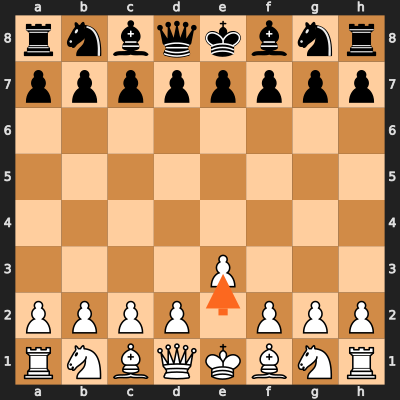

Ruch 2, Czarne
Najlepszy ruch: g8f6, Ocena: 4.30


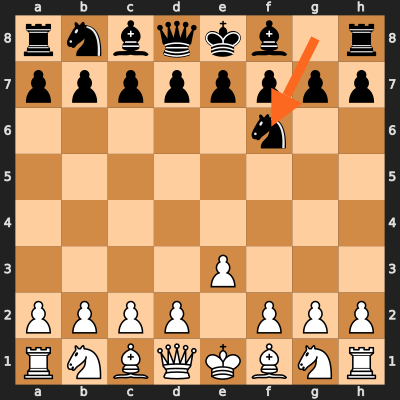

Ruch 3, Białe
Najlepszy ruch: b1c3, Ocena: 0.05


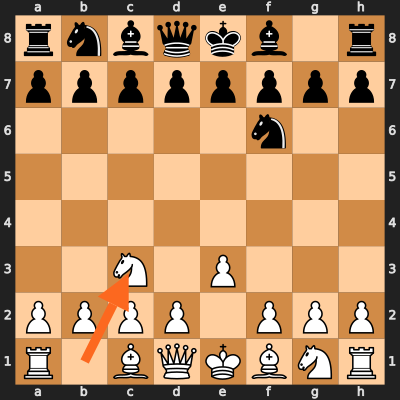

Ruch 4, Czarne
Najlepszy ruch: e7e5, Ocena: 4.20


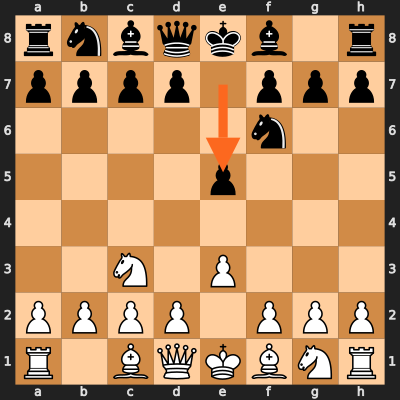

Ruch 5, Białe
Najlepszy ruch: a2a3, Ocena: -0.85


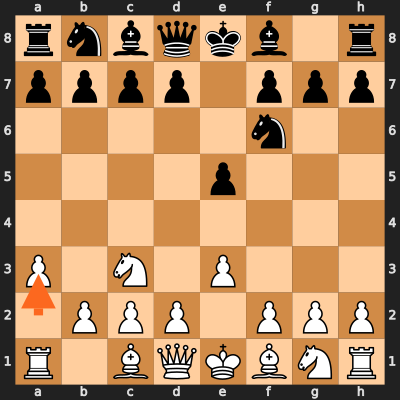

Ruch 6, Czarne
Najlepszy ruch: e5e4, Ocena: 3.15


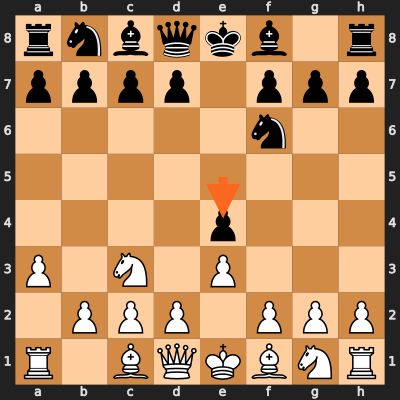

Ruch 7, Białe
Najlepszy ruch: d1e2, Ocena: -0.20


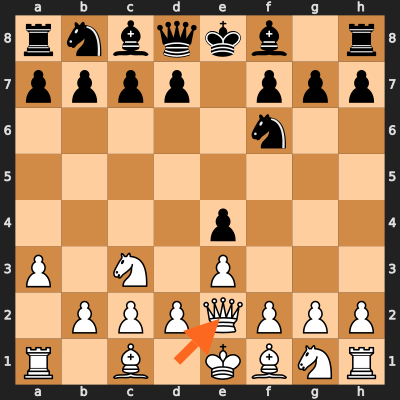

Ruch 8, Czarne
Najlepszy ruch: f8e7, Ocena: 3.80


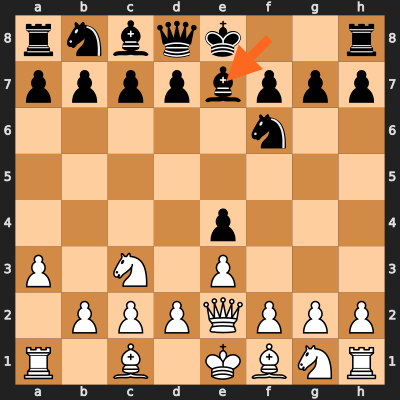

Ruch 9, Białe
Najlepszy ruch: e2b5, Ocena: 0.25


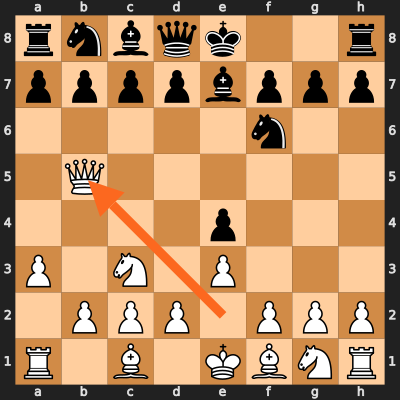

Ruch 10, Czarne
Najlepszy ruch: c7c5, Ocena: 3.85


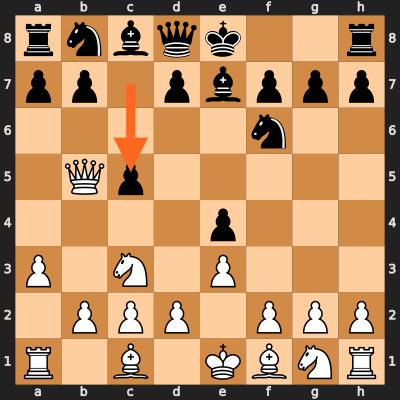

Ruch 11, Białe
Najlepszy ruch: f1c4, Ocena: 0.50


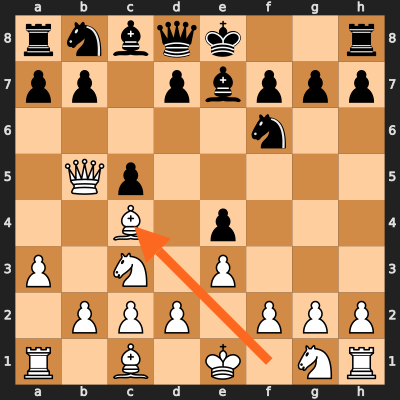

Ruch 12, Czarne
Najlepszy ruch: e8g8, Ocena: 3.35


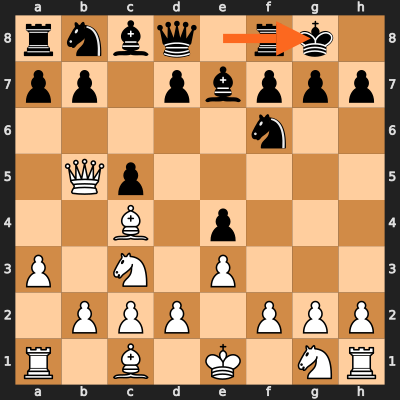

Ruch 13, Białe
Najlepszy ruch: c3d5, Ocena: 0.10


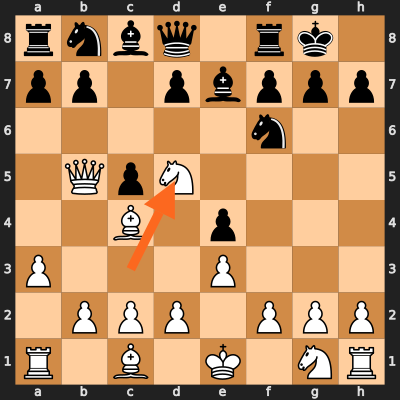

Ruch 14, Czarne
Najlepszy ruch: f6d5, Ocena: 3.05


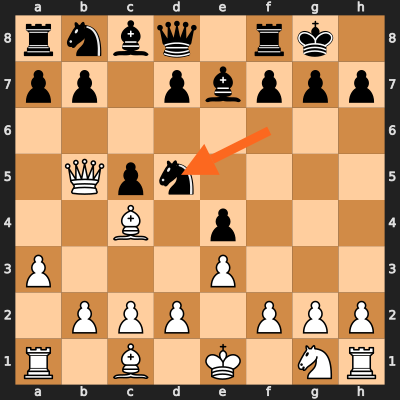

Ruch 15, Białe
Najlepszy ruch: c4d5, Ocena: 0.15


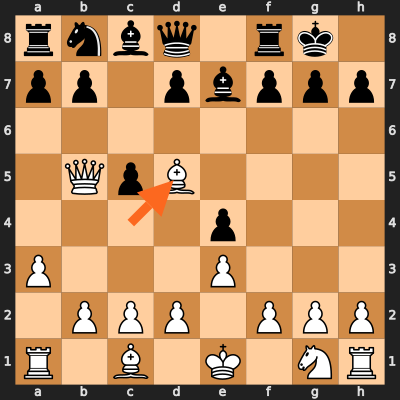

Ruch 16, Czarne
Najlepszy ruch: a7a6, Ocena: 3.00


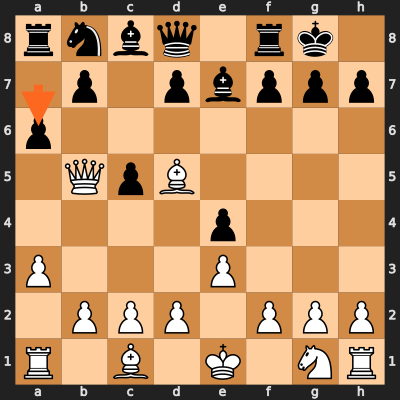

Ruch 17, Białe
Najlepszy ruch: b5a4, Ocena: -0.25


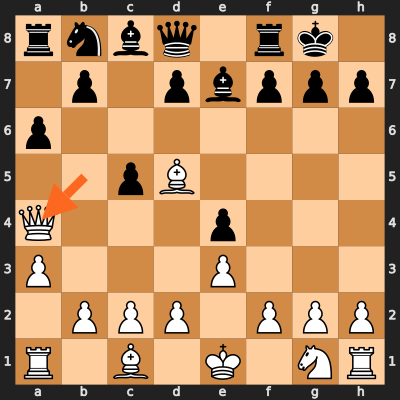

Ruch 18, Czarne
Najlepszy ruch: c5c4, Ocena: 4.85


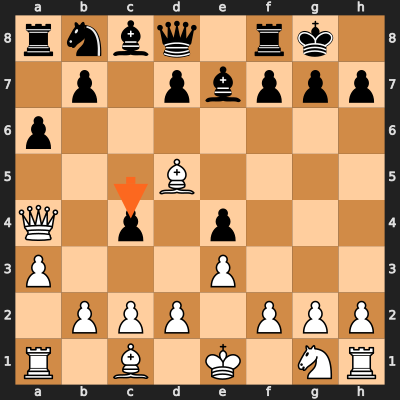

Ruch 19, Białe
Najlepszy ruch: a4c4, Ocena: -1.05


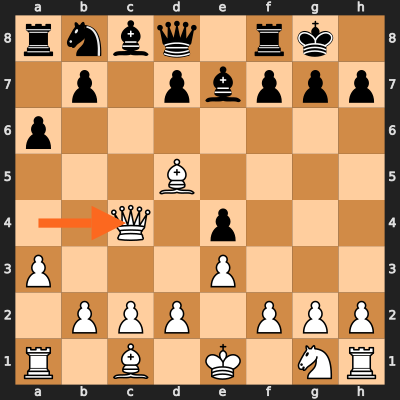

Ruch 20, Czarne
Najlepszy ruch: e7h4, Ocena: 6.30


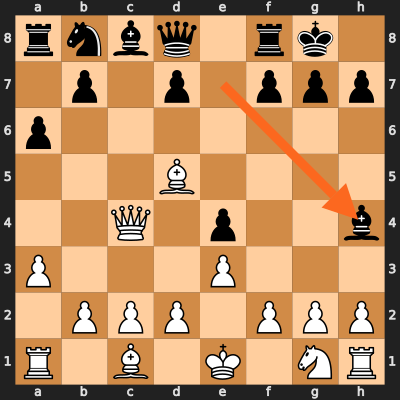

Ruch 21, Białe
Najlepszy ruch: c4e4, Ocena: -0.05


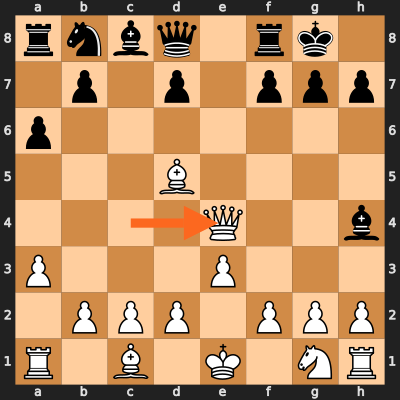

Ruch 22, Czarne
Najlepszy ruch: h4f2, Ocena: 5.70


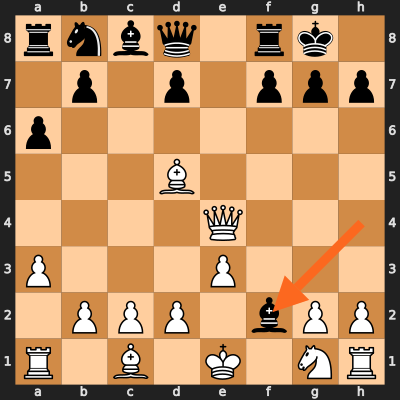

Ruch 23, Białe
Najlepszy ruch: e1f2, Ocena: 0.30


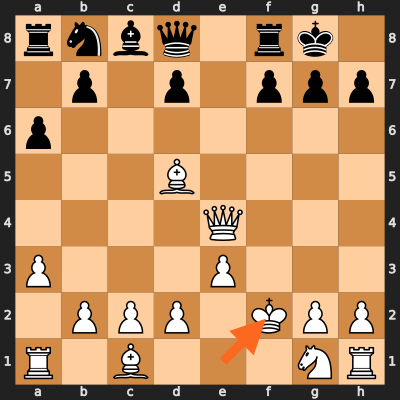

Ruch 24, Czarne
Najlepszy ruch: g8h8, Ocena: 8.60


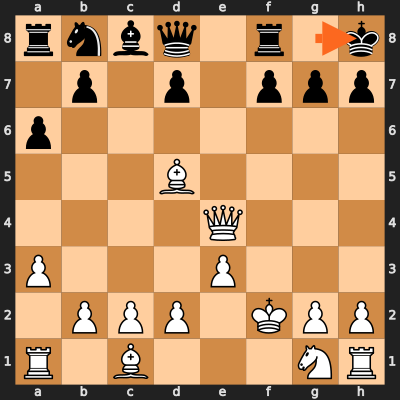

Ruch 25, Białe
Najlepszy ruch: e4f4, Ocena: 2.15


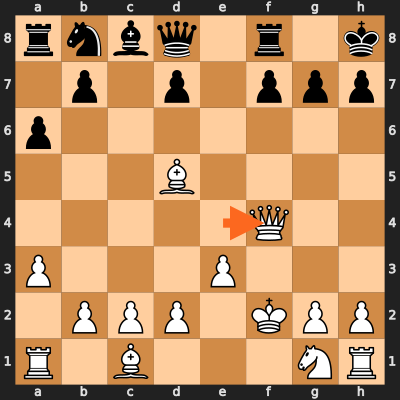

Ruch 26, Czarne
Najlepszy ruch: d8f6, Ocena: 6.90


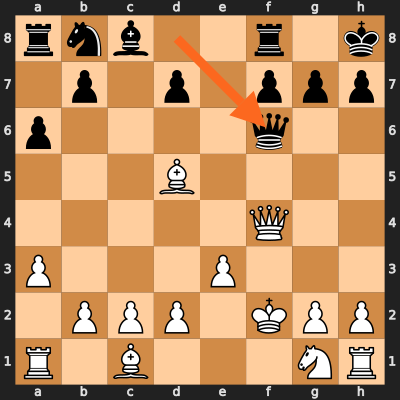

Ruch 27, Białe
Najlepszy ruch: f4f6, Ocena: 5.50


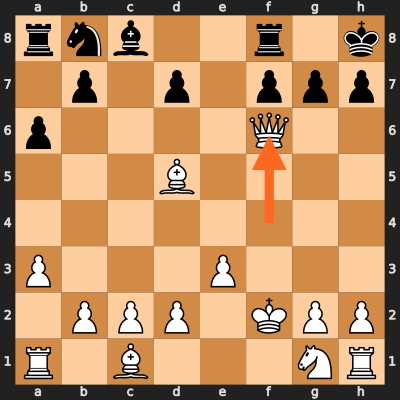

Ruch 28, Czarne
Najlepszy ruch: g7f6, Ocena: 7.20


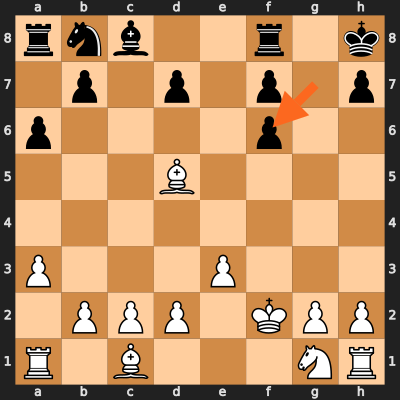

Ruch 29, Białe
Najlepszy ruch: g1f3, Ocena: 5.00


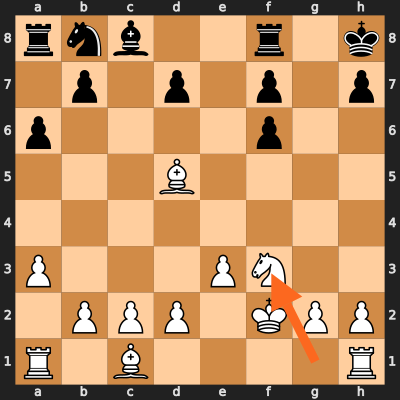

Ruch 30, Czarne
Najlepszy ruch: h7h6, Ocena: 7.60


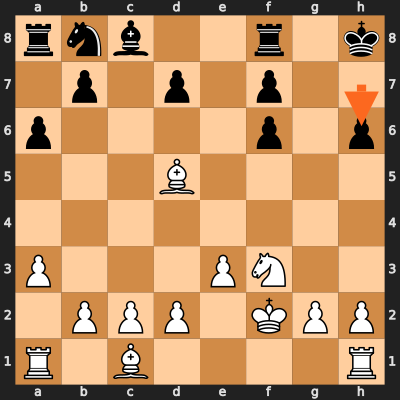

Ruch 31, Białe
Najlepszy ruch: d2d3, Ocena: 5.30


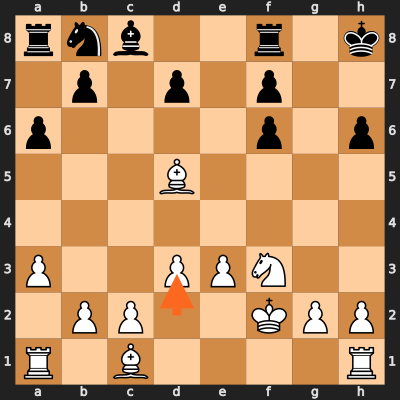

Ruch 32, Czarne
Najlepszy ruch: d7d6, Ocena: 8.35


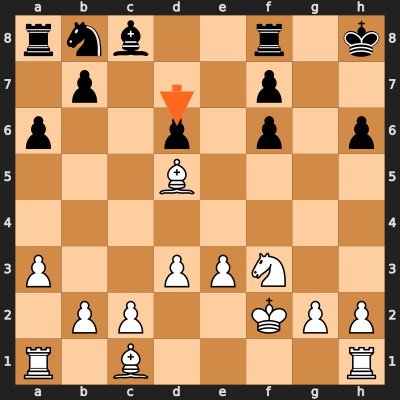

Ruch 33, Białe
Najlepszy ruch: c1d2, Ocena: 5.25


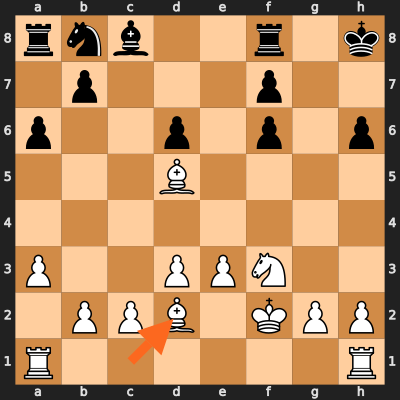

Ruch 34, Czarne
Najlepszy ruch: c8e6, Ocena: 8.35


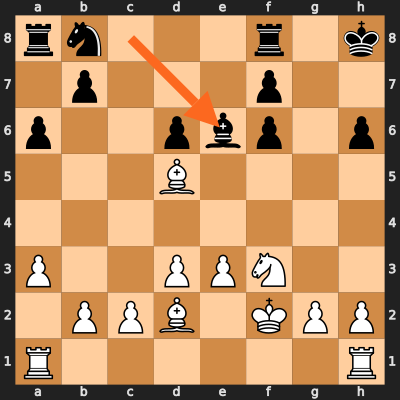

Ruch 35, Białe
Najlepszy ruch: d5b7, Ocena: 6.20


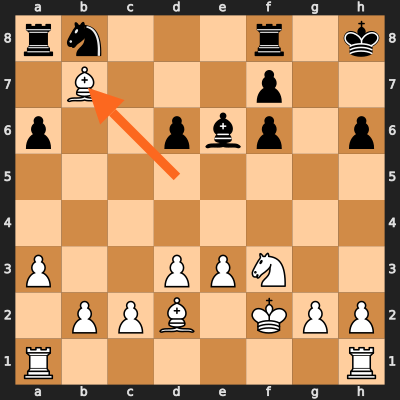

Ruch 36, Czarne
Najlepszy ruch: a8a7, Ocena: 8.25


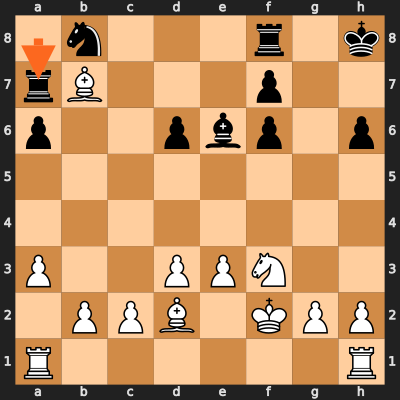

Ruch 37, Białe
Najlepszy ruch: b7e4, Ocena: 4.95


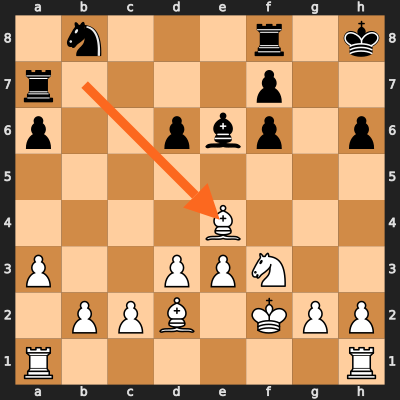

Ruch 38, Czarne
Najlepszy ruch: d6d5, Ocena: 8.95


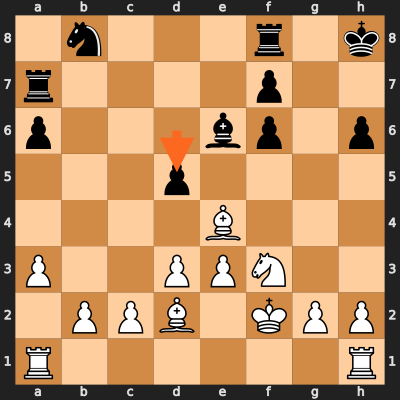

Ruch 39, Białe
Najlepszy ruch: d2c3, Ocena: 4.60


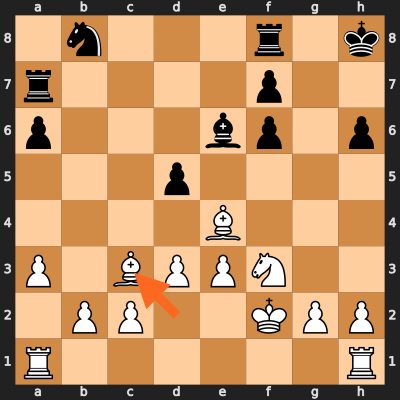

Ruch 40, Czarne
Najlepszy ruch: d5e4, Ocena: 6.80


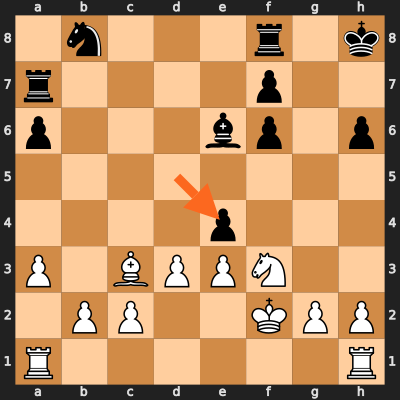

Ruch 41, Białe
Najlepszy ruch: c3f6, Ocena: 5.40


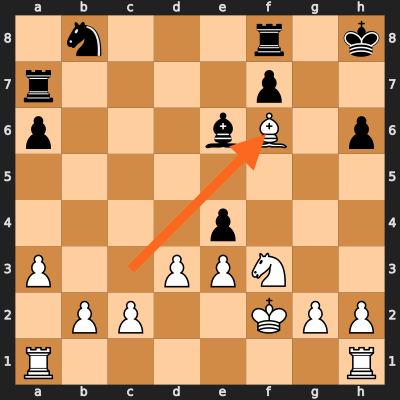

Ruch 42, Czarne
Najlepszy ruch: h8g8, Ocena: 6.55


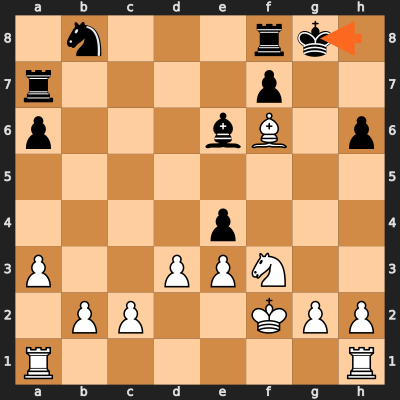

Ruch 43, Białe
Najlepszy ruch: d3e4, Ocena: 4.45


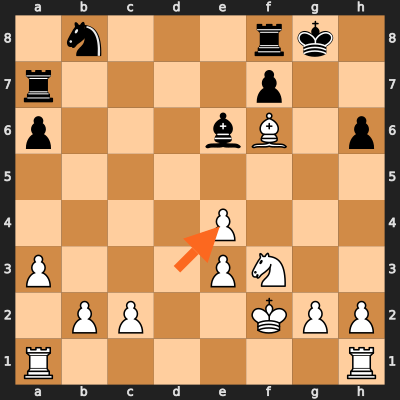

Ruch 44, Czarne
Najlepszy ruch: b8d7, Ocena: 5.70


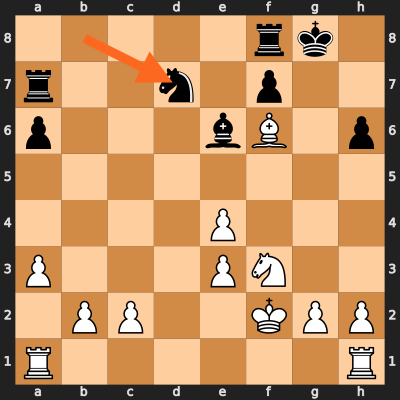

Ruch 45, Białe
Najlepszy ruch: f6d4, Ocena: 4.05


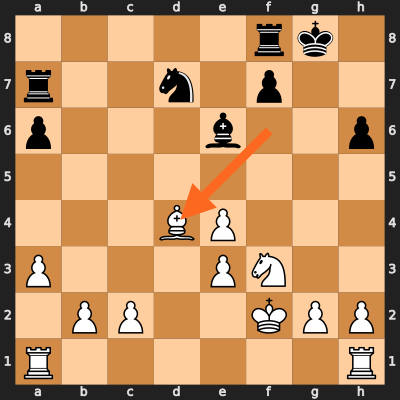

Ruch 46, Czarne
Najlepszy ruch: a7b7, Ocena: 5.15


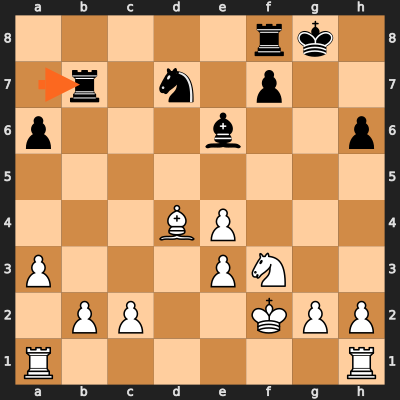

Ruch 47, Białe
Najlepszy ruch: b2b4, Ocena: 3.40


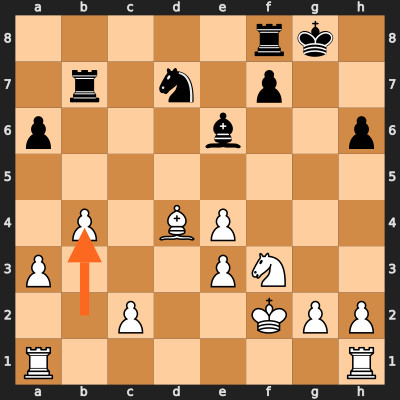

Ruch 48, Czarne
Najlepszy ruch: f8c8, Ocena: 4.35


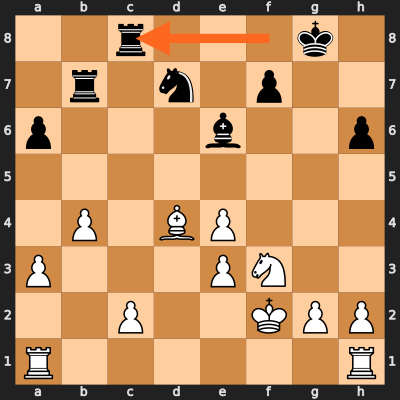

Ruch 49, Białe
Najlepszy ruch: c2c3, Ocena: 1.10


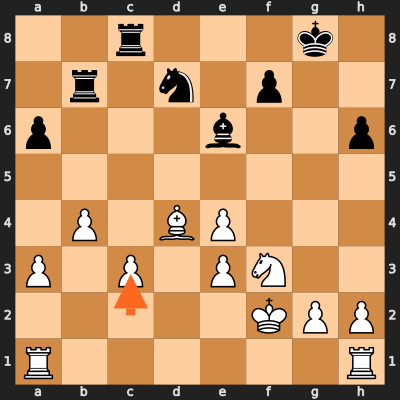

Ruch 50, Czarne
Najlepszy ruch: e6g4, Ocena: 4.20


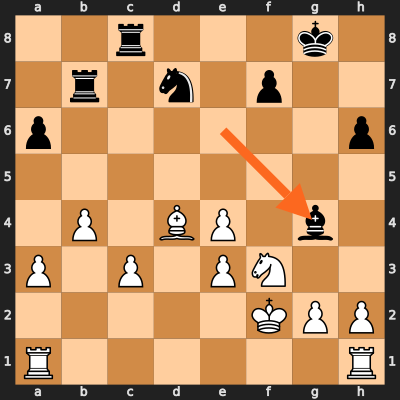

Ruch 51, Białe
Najlepszy ruch: h2h3, Ocena: 2.85


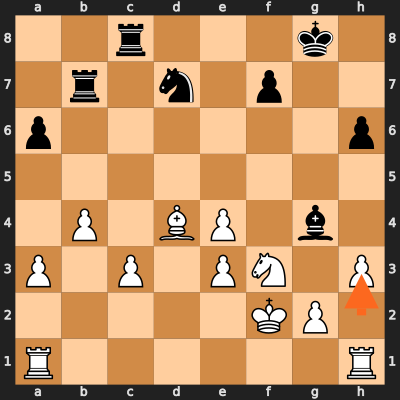

Ruch 52, Czarne
Najlepszy ruch: g4f3, Ocena: 4.45


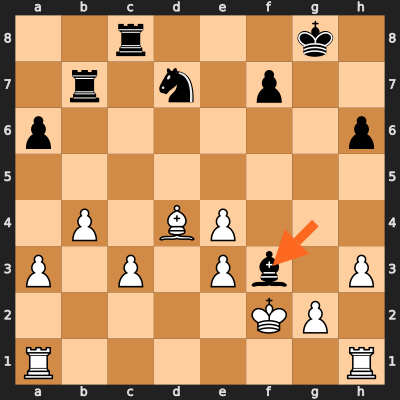

Ruch 53, Białe
Najlepszy ruch: g2f3, Ocena: 3.15


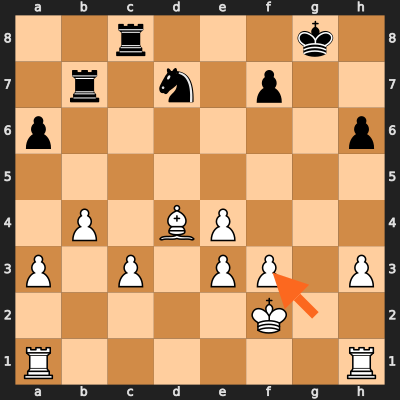

Ruch 54, Czarne
Najlepszy ruch: g8f8, Ocena: 7.00


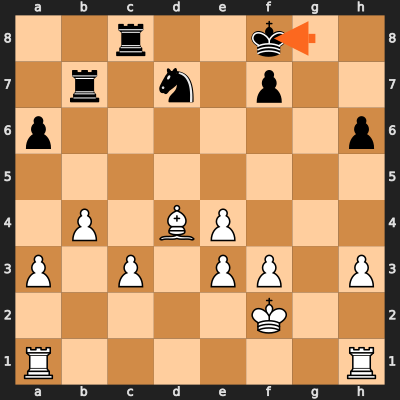

Ruch 55, Białe
Najlepszy ruch: h1g1, Ocena: 3.05


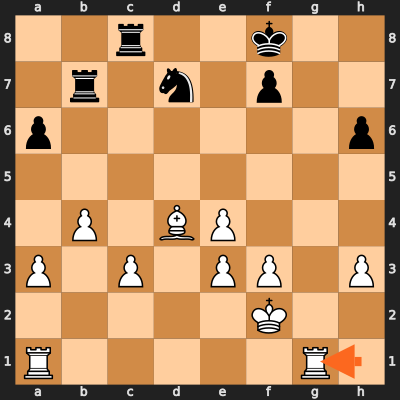

Ruch 56, Czarne
Najlepszy ruch: c8c4, Ocena: 7.35


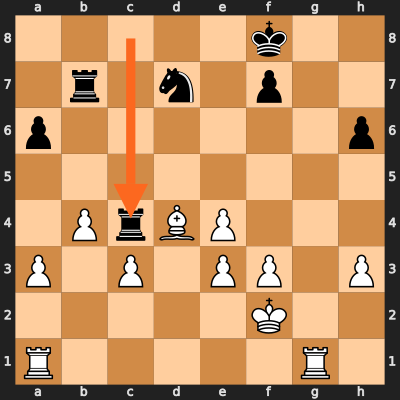

Ruch 57, Białe
Najlepszy ruch: d4g7, Ocena: 3.60


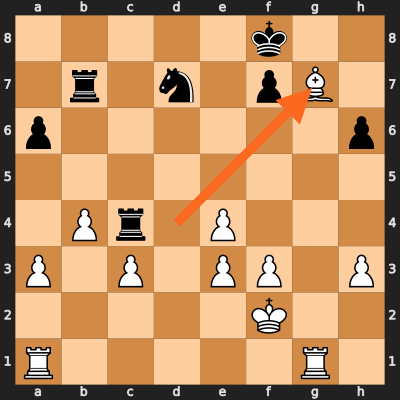

Ruch 58, Czarne
Najlepszy ruch: f8e7, Ocena: 7.45


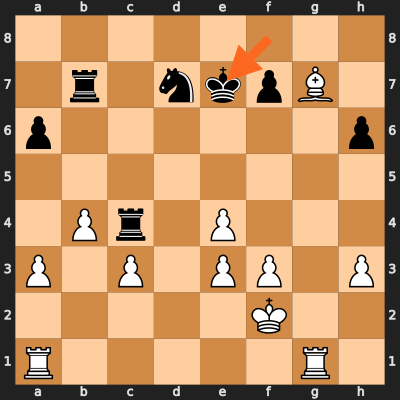

Ruch 59, Białe
Najlepszy ruch: g7h6, Ocena: 3.65


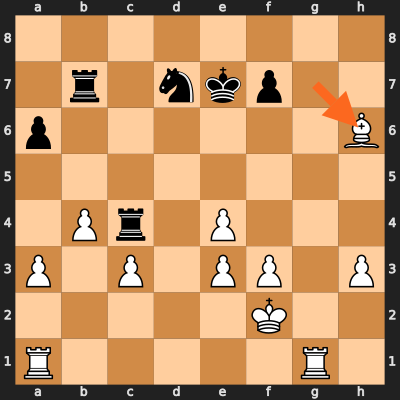

Ruch 60, Czarne
Najlepszy ruch: c4c3, Ocena: 6.20


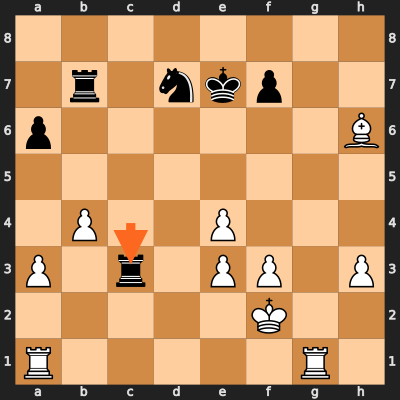

Ruch 61, Białe
Najlepszy ruch: g1c1, Ocena: 3.30


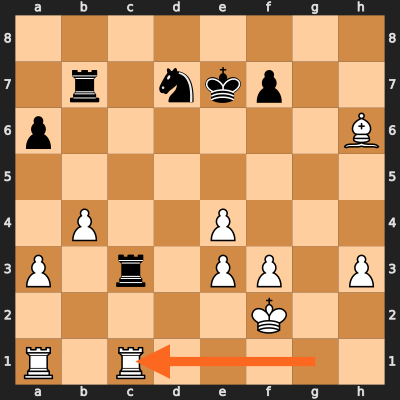

Ruch 62, Czarne
Najlepszy ruch: c3c1, Ocena: 6.65


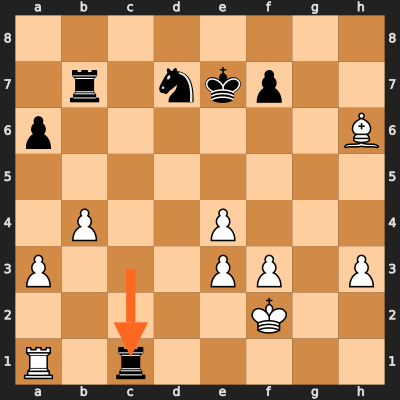

Ruch 63, Białe
Najlepszy ruch: a1c1, Ocena: 4.00


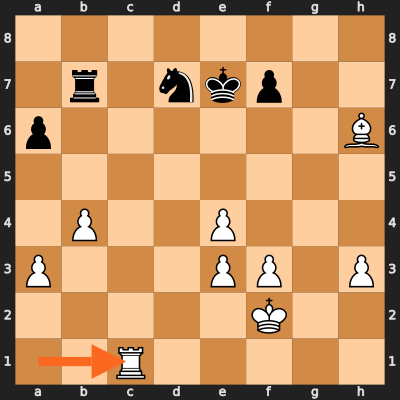

Ruch 64, Czarne
Najlepszy ruch: d7e5, Ocena: 6.75


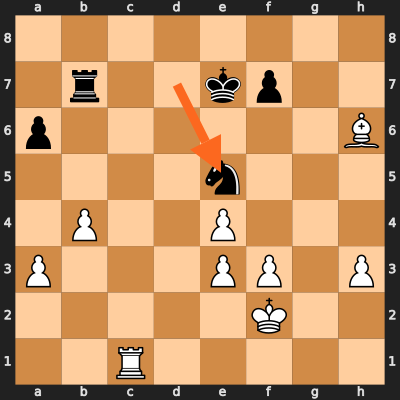

Ruch 65, Białe
Najlepszy ruch: f2g2, Ocena: 3.60


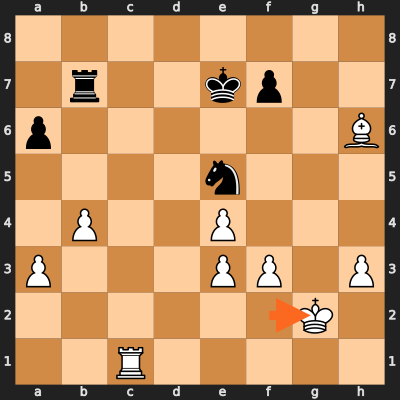

Ruch 66, Czarne
Najlepszy ruch: e7d7, Ocena: 6.80


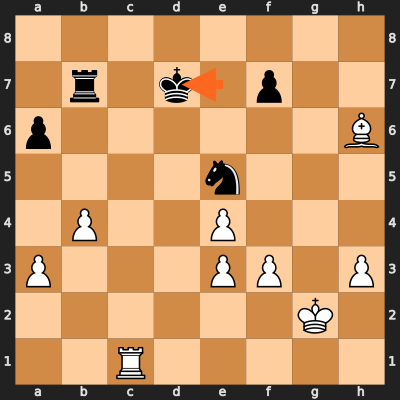

Ruch 67, Białe
Najlepszy ruch: h6f4, Ocena: 3.85


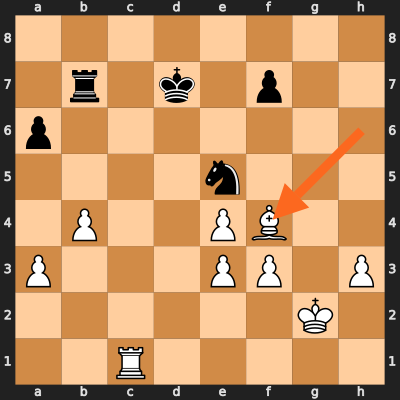

Ruch 68, Czarne
Najlepszy ruch: e5g6, Ocena: 7.40


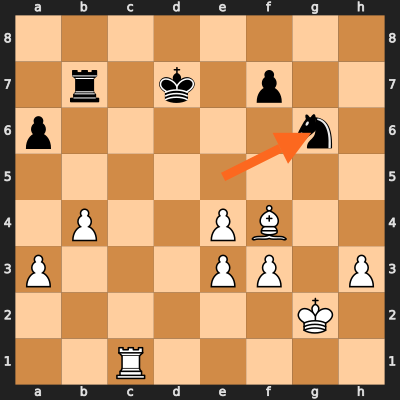

Ruch 69, Białe
Najlepszy ruch: f4g5, Ocena: 4.90


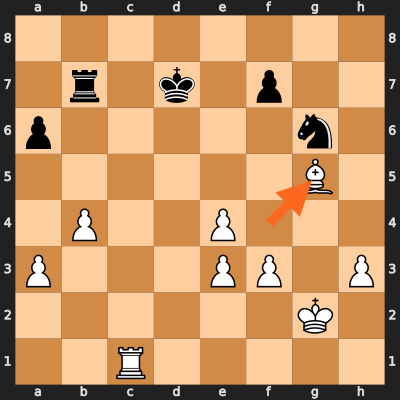

Ruch 70, Czarne
Najlepszy ruch: g6e5, Ocena: 7.25


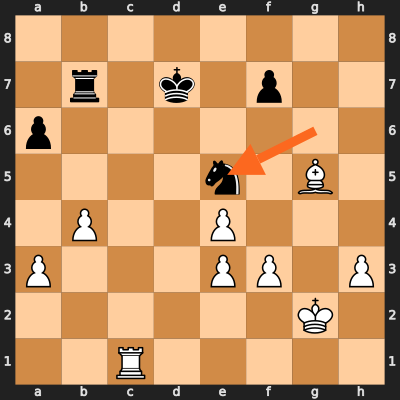

Ruch 71, Białe
Najlepszy ruch: g5f6, Ocena: 4.40


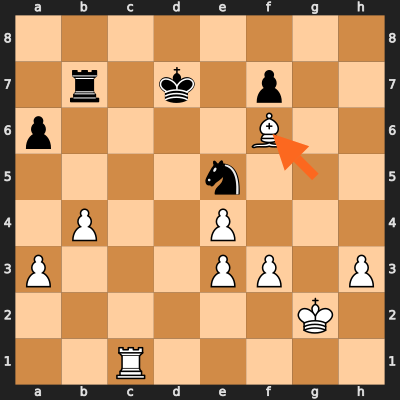

Ruch 72, Czarne
Najlepszy ruch: d7e6, Ocena: 7.45


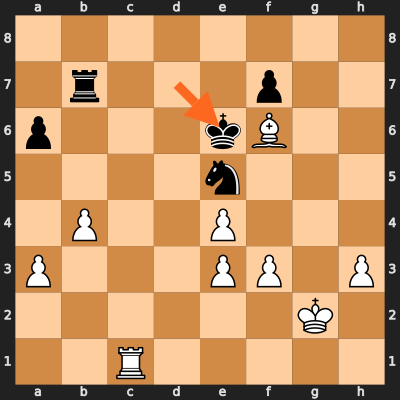

Ruch 73, Białe
Najlepszy ruch: f6e5, Ocena: 5.45


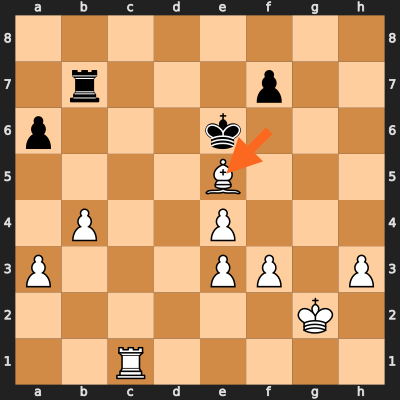

Ruch 74, Czarne
Najlepszy ruch: e6e5, Ocena: 7.65


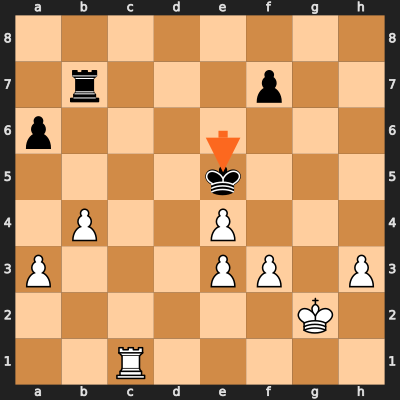

Ruch 75, Białe
Najlepszy ruch: c1c5, Ocena: 5.05


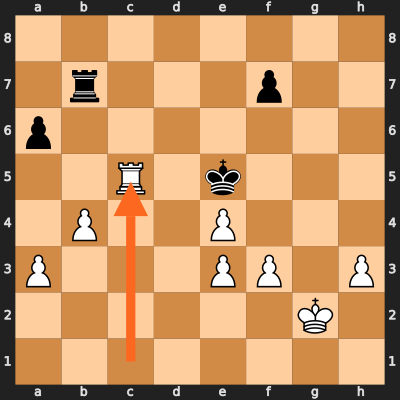

Ruch 76, Czarne
Najlepszy ruch: e5f6, Ocena: 6.45


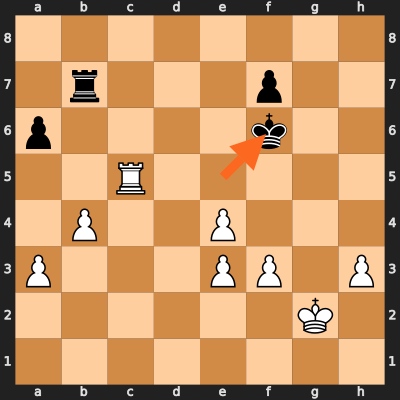

Ruch 77, Białe
Najlepszy ruch: h3h4, Ocena: 4.60


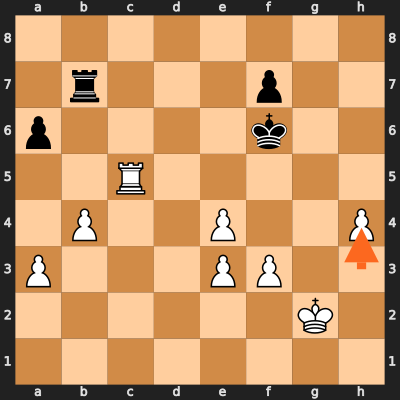

Ruch 78, Czarne
Najlepszy ruch: f6g7, Ocena: 6.35


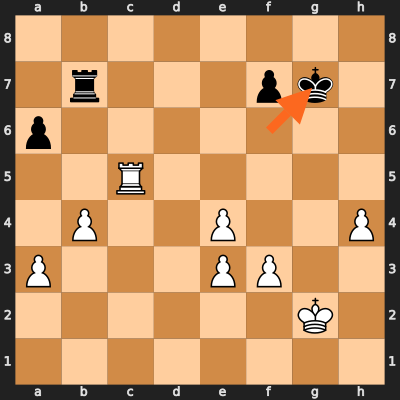

Ruch 79, Białe
Najlepszy ruch: f3f4, Ocena: 4.30


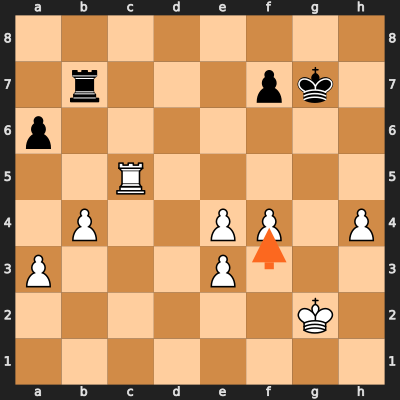

Ruch 80, Czarne
Najlepszy ruch: b7e7, Ocena: 6.40


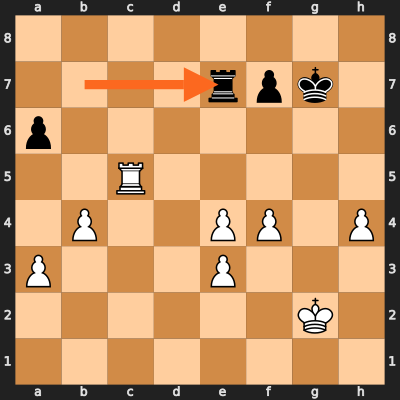

Ruch 81, Białe
Najlepszy ruch: c5e5, Ocena: 4.55


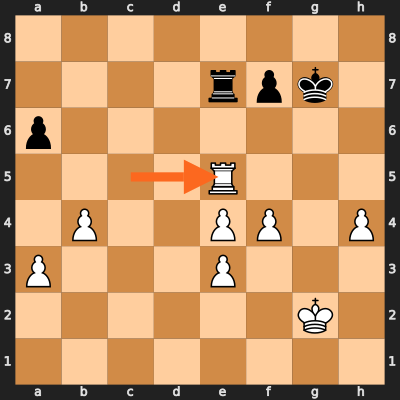

Ruch 82, Czarne
Najlepszy ruch: e7e5, Ocena: 4.90


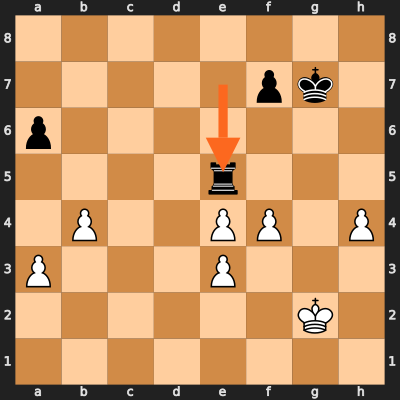

Ruch 83, Białe
Najlepszy ruch: f4e5, Ocena: 4.45


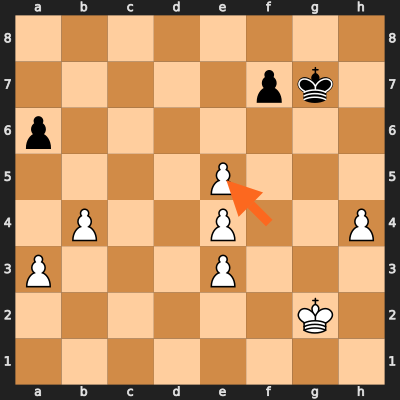

Ruch 84, Czarne
Najlepszy ruch: g7h6, Ocena: 4.65


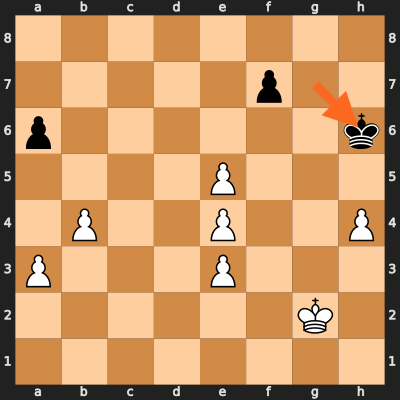

Ruch 85, Białe
Najlepszy ruch: a3a4, Ocena: 4.45


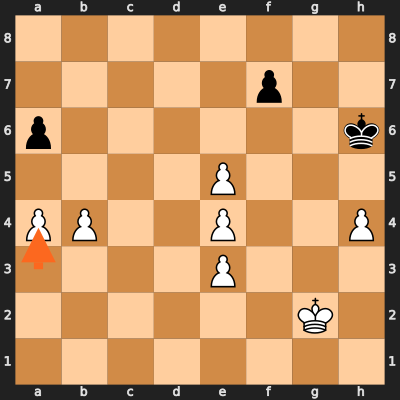

Ruch 86, Czarne
Najlepszy ruch: h6h7, Ocena: 4.90


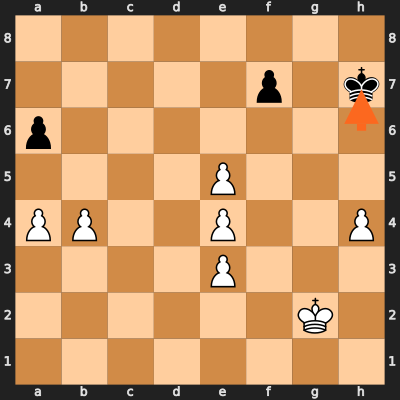

Ruch 87, Białe
Najlepszy ruch: b4b5, Ocena: 4.55


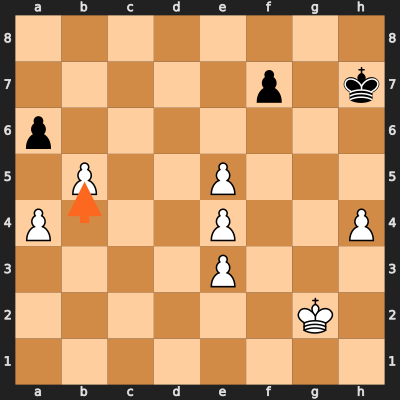

Ruch 88, Czarne
Najlepszy ruch: a6b5, Ocena: 4.75


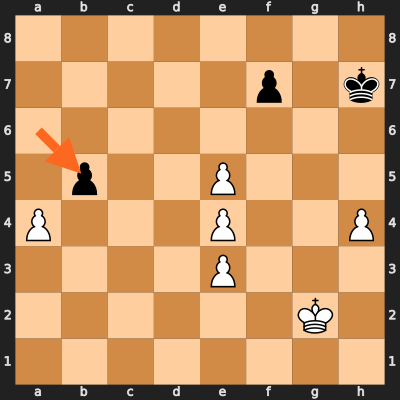

Ruch 89, Białe
Najlepszy ruch: a4b5, Ocena: 4.60


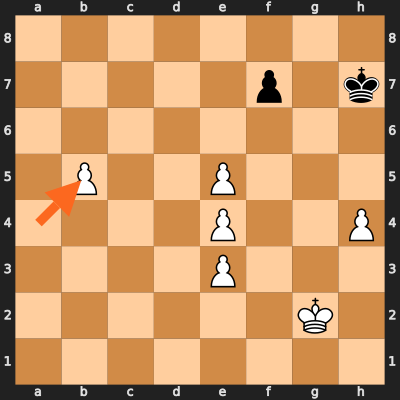

Ruch 90, Czarne
Najlepszy ruch: h7h8, Ocena: 5.30


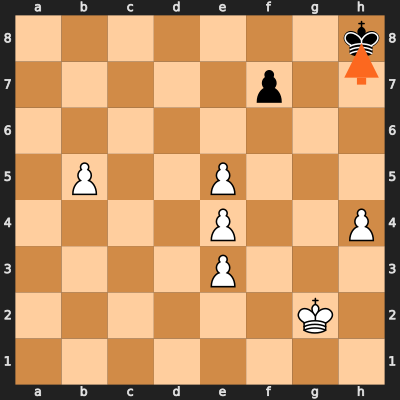

Ruch 91, Białe
Najlepszy ruch: b5b6, Ocena: 5.30


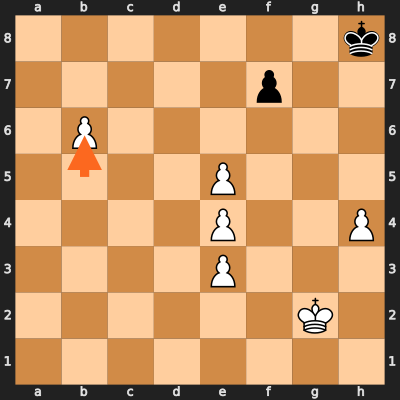

Ruch 92, Czarne
Najlepszy ruch: f7f5, Ocena: 13.80


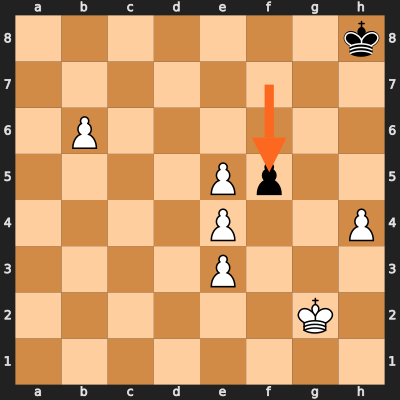

Ruch 93, Białe
Najlepszy ruch: b6b7, Ocena: 13.10


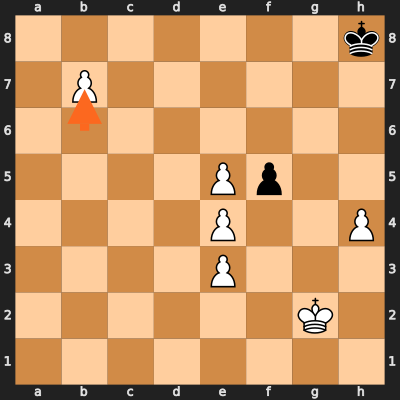

Ruch 94, Czarne
Najlepszy ruch: f5e4, Ocena: 14.00


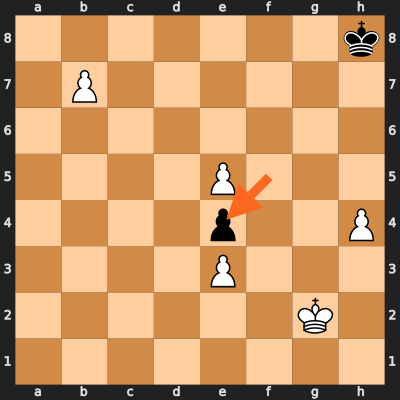

Ruch 95, Białe
Najlepszy ruch: b7b8q, Ocena: 13.80


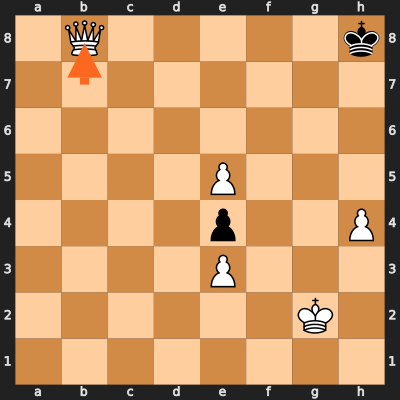

Ruch 96, Czarne
Najlepszy ruch: h8g7, Ocena: 14.50


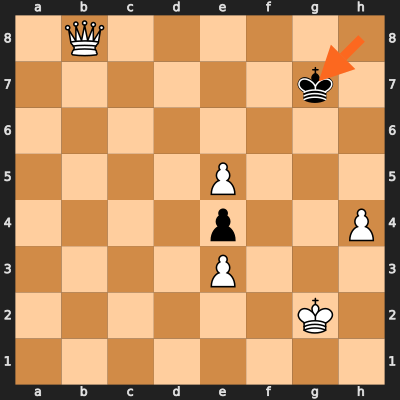

Ruch 97, Białe
Najlepszy ruch: b8b7, Ocena: 14.35


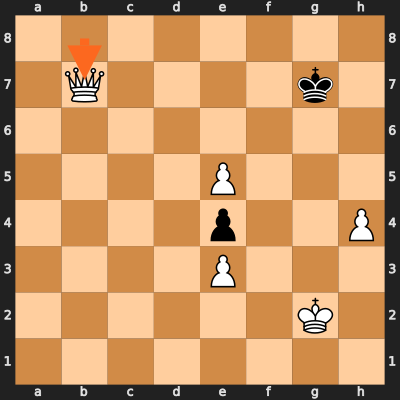

Ruch 98, Czarne
Najlepszy ruch: g7h8, Ocena: 15.40


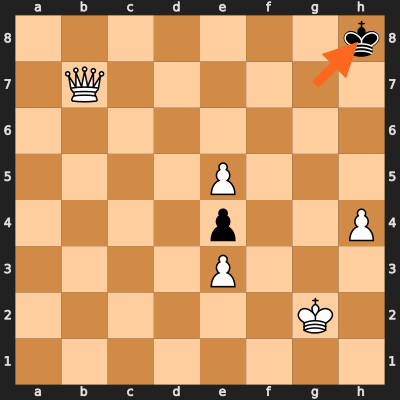

Ruch 99, Białe
Najlepszy ruch: b7e4, Ocena: 15.25


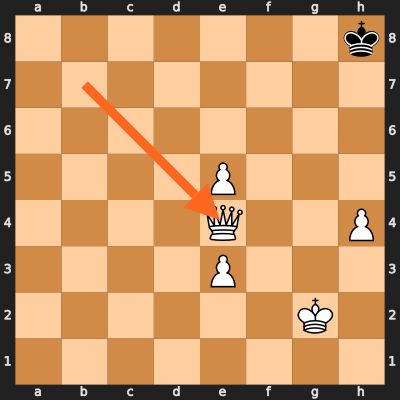

Ruch 100, Czarne
Najlepszy ruch: h8g7, Ocena: 15.60


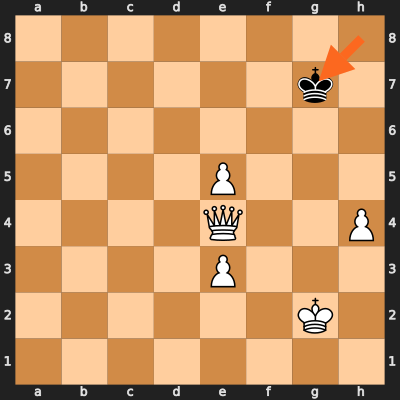

Ruch 101, Białe
Najlepszy ruch: h4h5, Ocena: 15.40


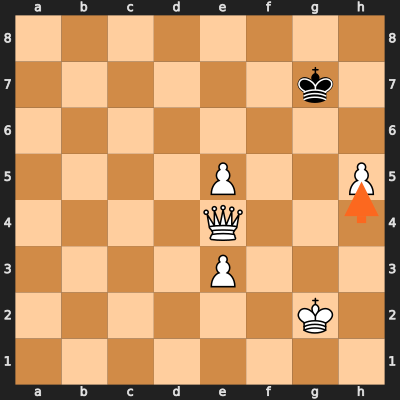

Ruch 102, Czarne
Najlepszy ruch: g7f7, Ocena: 15.85


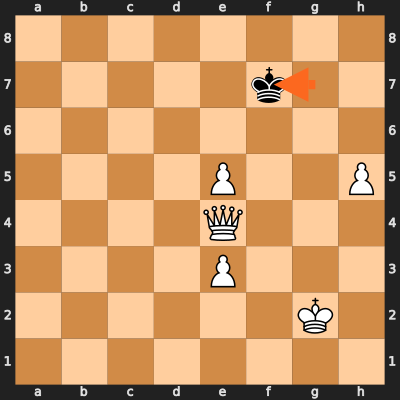

Ruch 103, Białe
Najlepszy ruch: e4d5, Ocena: 15.45


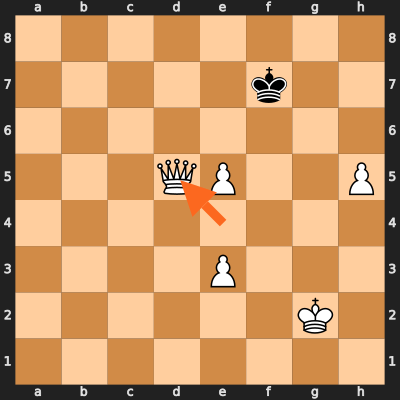

Ruch 104, Czarne
Najlepszy ruch: f7e8, Ocena: 16.10


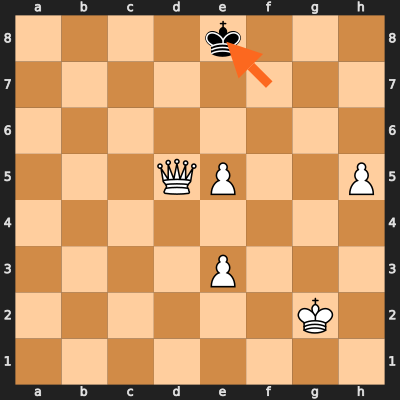

Ruch 105, Białe
Najlepszy ruch: d5c4, Ocena: 15.65


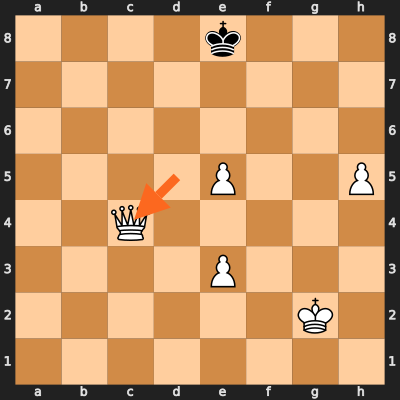

Ruch 106, Czarne
Najlepszy ruch: e8f8, Ocena: 16.35


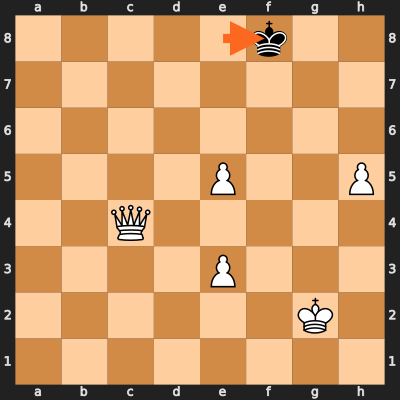

Ruch 107, Białe
Najlepszy ruch: h5h6, Ocena: 16.35


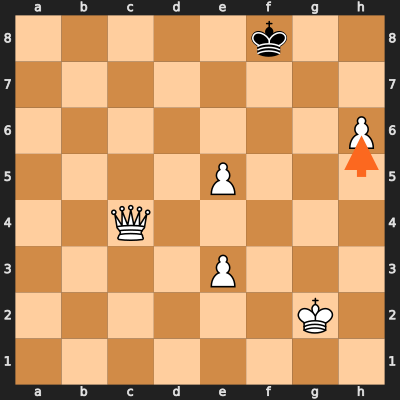

Ruch 108, Czarne
Najlepszy ruch: f8e8, Ocena: 25.05


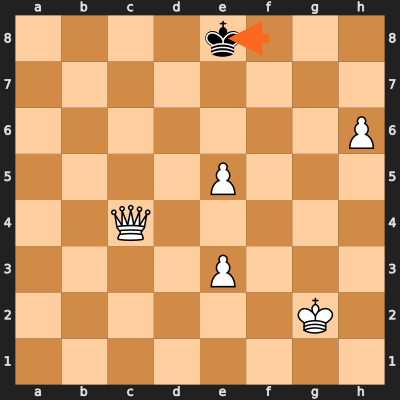

Ruch 109, Białe
Najlepszy ruch: h6h7, Ocena: 25.15


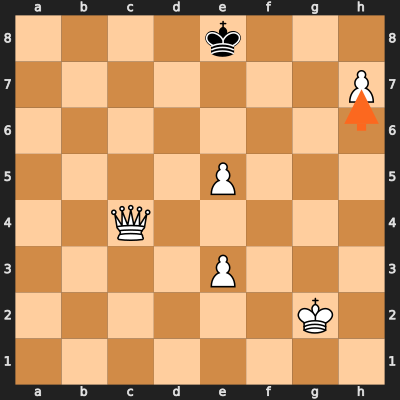

Ruch 110, Czarne
Najlepszy ruch: e8e7, Ocena: 26.05


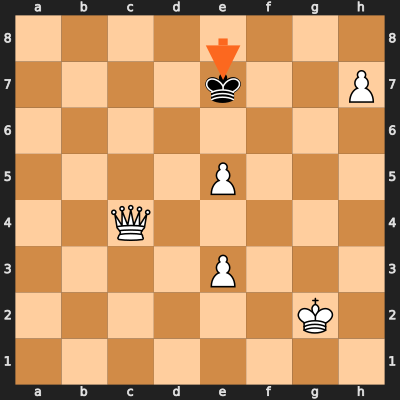

Ruch 111, Białe
Najlepszy ruch: h7h8q, Ocena: 25.80


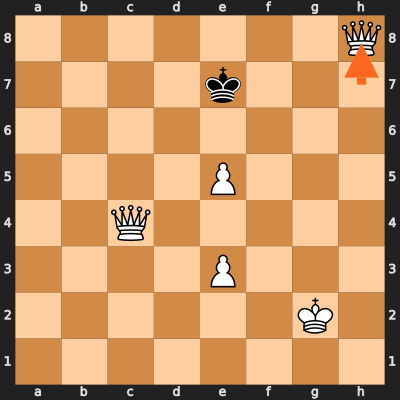

Ruch 112, Czarne
Najlepszy ruch: e7d7, Ocena: 9999.00


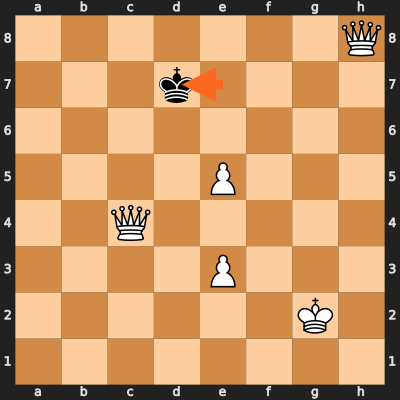

Ruch 113, Białe
Najlepszy ruch: h8c8, Ocena: 9999.00


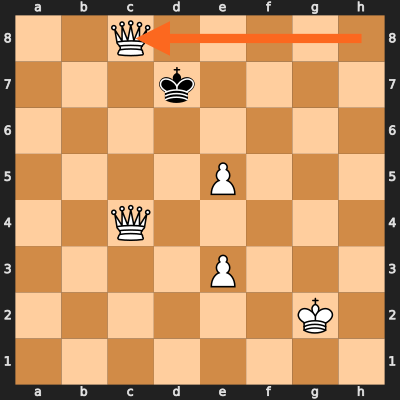

Ruch 114, Czarne
Najlepszy ruch: d7e7, Ocena: 9999.00


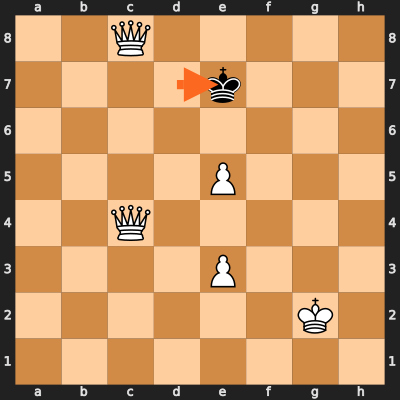

Ruch 115, Białe
Najlepszy ruch: c8c7, Ocena: 9999.00


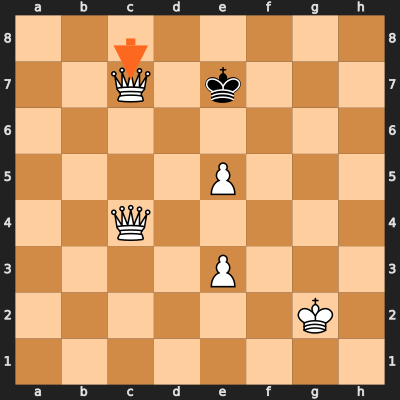

Ruch 116, Czarne
Najlepszy ruch: e7f8, Ocena: 9999.00


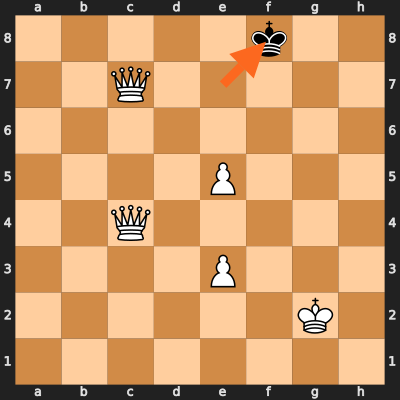

Ruch 117, Białe
Najlepszy ruch: c7f7, Ocena: 9999.00


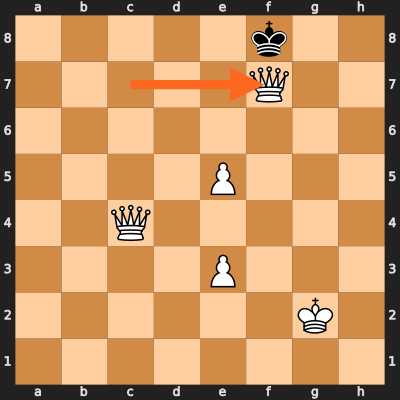


Gra zakończona po 117 ruchach
Wynik: 1-0


In [6]:
game()